# VQVAE for Image Generation - FashionMNIST Dataset
**Author:** Jeanne Malécot 

## Getting Started

In [2]:
#useful imports
import os
import copy

import torch
import torchvision
import torchvision.transforms as transforms
import torchinfo
import random

import matplotlib.pyplot as plt

from scripts.train import train_model
from scripts.reconstruct import reconstruct, show_recon
from models.vqvae import VQVAE

##### Load FashionMNIST dataset

In [3]:
#load FashionMNIST
train_set = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_set = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

print(f"len train set: {len(train_set)}\nlen test set: {len(test_set)}")
print(f"image shape: {train_set[0][0][0].shape}")

len train set: 60000
len test set: 10000
image shape: torch.Size([28, 28])


## Training VQVAE for reconstruction

In [4]:
#device
device = "cuda" if torch.cuda.is_available() else "cpu"
print('device:', device)

device: cuda


In [23]:
#config
config = {
    'n_epochs': 30, 
    'lr': 0.001, 
    'alpha': 0.25,
    'model': {
        'batch_size': 100, 
        'n_channels': 1, 
        'channels': [32, 64, 128],
        'latent_dim': 32,
        'n_embedding': 40,
        }
    } 

Model architecture:

In [24]:
vqvae = vqvae = VQVAE(config['model']).to(device)
torchinfo.summary(vqvae, (1, 1, 28,28), device = str(device))


Layer (type:depth-idx)                        Output Shape              Param #
VQVAE                                         [1, 1, 28, 28]            --
├─EncoderBlock: 1-1                           [1, 32, 7, 7]             --
│    └─ModuleList: 2-1                        --                        --
│    │    └─Sequential: 3-1                   [1, 32, 28, 28]           320
│    │    └─Sequential: 3-2                   [1, 64, 14, 14]           18,496
│    │    └─Sequential: 3-3                   [1, 128, 7, 7]            73,856
│    │    └─Sequential: 3-4                   [1, 32, 7, 7]             4,128
├─VectorQuantizer: 1-2                        [1, 32, 7, 7]             1,280
├─DecoderBlock: 1-3                           [1, 1, 56, 56]            --
│    └─ModuleList: 2-2                        --                        --
│    │    └─Sequential: 3-5                   [1, 128, 7, 7]            4,224
│    │    └─Sequential: 3-6                   [1, 64, 14, 14]           32,83

#### Fine tuning of the VQ-VAE

In [25]:
# config = copy.deepcopy(basic_config)
model_dict = train_model("vqvae", train_set, config, device)
print(f"Training Loss: {model_dict['train_loss']:.4f} | Validation Loss: {model_dict['val_loss']:.4f}")

Output()

Training Loss: 0.0062 | Validation Loss: 0.0063


Reconstructing images:   0%|          | 0/10000 [00:00<?, ?it/s]

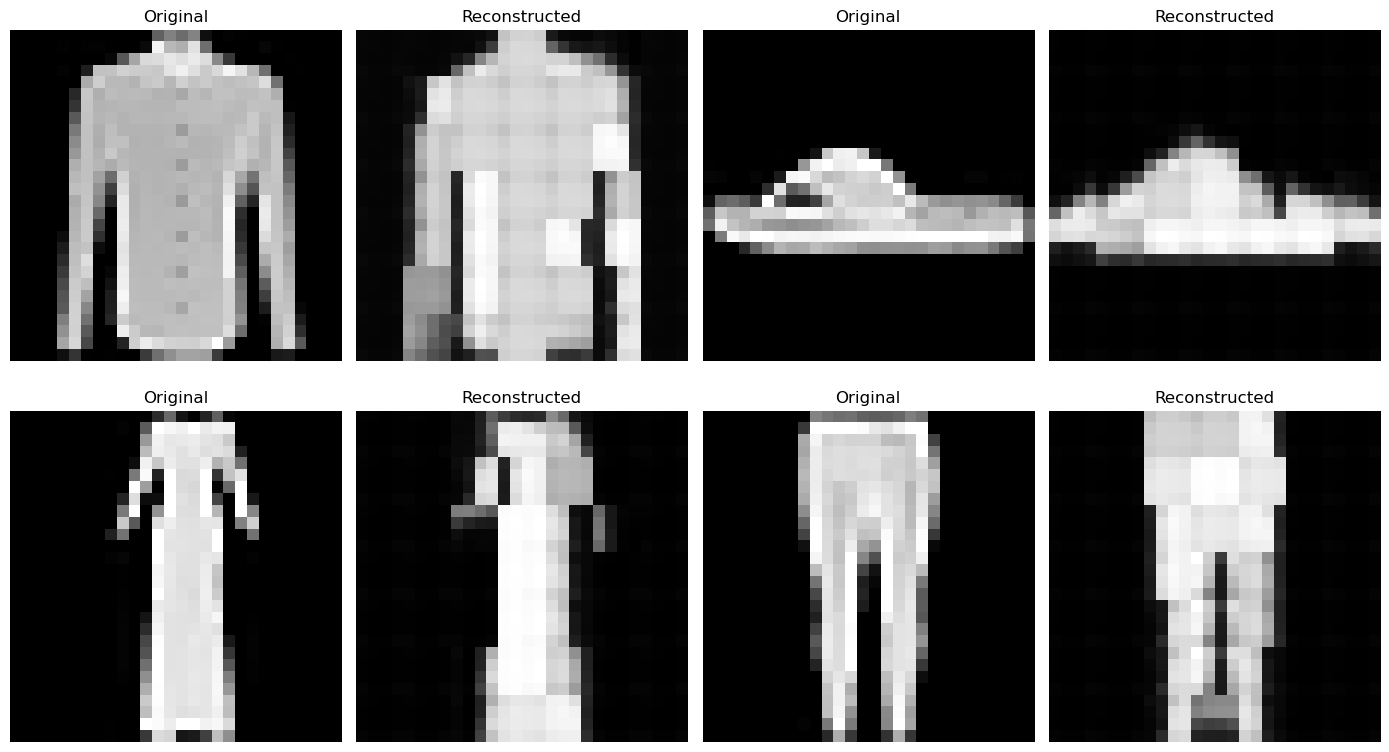

In [26]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress  ",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
model = model_dict['model']

image_dicts, label_dist = reconstruct(model, test_set, device)
show_recon(image_dicts)

In [27]:
import numpy as np

L = []
for image_dict in image_dicts:
    L.append(len(np.unique(image_dict['latent_indices'])))

print(max(L))

25


torch.Size([28, 28])


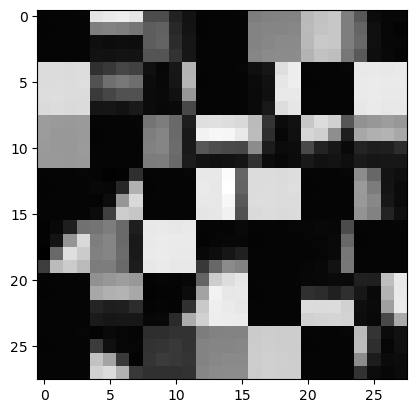

In [10]:
#generate sneakers
sneakers_dist = label_dist[8]
# print(sneakers_dist)

generated_image = model.generate(sneakers_dist, (28,28))
print(generated_image.shape)
plt.imshow(generated_image.detach().cpu().numpy(), cmap = 'gray')